# SHAP-IQ with scikit-learn

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

### Import Packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

'1.2.3'

### Load Data
Let's load the California housing dataset and split it into training and test sets.

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### Train a Model with Scikit-learn
Here we train a random forest regressor with 500 trees.
The model achieves a relatively high R2 score on the test set.

In [3]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.7990
Test  R2: 0.7462


### Model-Agnostic Explainer

We use `shapiq.TabularExplainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:

- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.

- `data`: A background dataset to be used for imputation.

In [4]:
explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train, index="SII", max_order=2)

Next, select an instance to be explained.

In [5]:
x = X_test[24]

Call an `explain()` interface setting the `budget`, i.e. the maximum number of model evaluations (coallitions).

In [6]:
interaction_values = explainer_tabular.explain(x, budget=2**n_features, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0699756848160713
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
interaction_values.dict_values

{(): 0.0,
 (0,): 0.061263220114449304,
 (1,): -0.06765797236822807,
 (2,): -0.05183156753815934,
 (3,): -0.01895729528481671,
 (4,): -0.01552235155839446,
 (5,): -0.09018493114438118,
 (6,): 0.14773163120173638,
 (7,): -0.27243323465457925,
 (0, 1): -0.00011730768161536039,
 (0, 2): 0.0355657995781812,
 (0, 3): 0.01890457270151627,
 (0, 4): 0.020599908576399574,
 (0, 5): -0.03877054121006674,
 (0, 6): -0.029680895709205145,
 (0, 7): 0.04966483044130361,
 (1, 2): 0.021241021085227706,
 (1, 3): 0.022374944569005538,
 (1, 4): 0.021722773027542854,
 (1, 5): 0.08448675534448771,
 (1, 6): 0.01745888339489944,
 (1, 7): 0.021566117444531976,
 (2, 3): 0.018327044510235247,
 (2, 4): 0.02114325640464587,
 (2, 5): 0.020230215932207155,
 (2, 6): 0.026746147241803058,
 (2, 7): 0.010162462578931964,
 (3, 4): 0.020808280015594035,
 (3, 5): 0.02386386665199122,
 (3, 6): 0.018304423176486437,
 (3, 7): 0.021711405902739206,
 (4, 5): 0.015424723818781658,
 (4, 6): 0.019938865246351977,
 (4, 7): 0.02186961

One can retrieve only 2-order values with `get_n_order(2)` (object) and `get_n_order_values(2)` (values themselves).

In [8]:
interaction_values.get_n_order(2).dict_values

{(0, 1): -0.00011730768161536039,
 (0, 2): 0.0355657995781812,
 (0, 3): 0.01890457270151627,
 (0, 4): 0.020599908576399574,
 (0, 5): -0.03877054121006674,
 (0, 6): -0.029680895709205145,
 (0, 7): 0.04966483044130361,
 (1, 2): 0.021241021085227706,
 (1, 3): 0.022374944569005538,
 (1, 4): 0.021722773027542854,
 (1, 5): 0.08448675534448771,
 (1, 6): 0.01745888339489944,
 (1, 7): 0.021566117444531976,
 (2, 3): 0.018327044510235247,
 (2, 4): 0.02114325640464587,
 (2, 5): 0.020230215932207155,
 (2, 6): 0.026746147241803058,
 (2, 7): 0.010162462578931964,
 (3, 4): 0.020808280015594035,
 (3, 5): 0.02386386665199122,
 (3, 6): 0.018304423176486437,
 (3, 7): 0.021711405902739206,
 (4, 5): 0.015424723818781658,
 (4, 6): 0.019938865246351977,
 (4, 7): 0.021869610479261753,
 (5, 6): 0.008617332840780175,
 (5, 7): 0.026962075643242604,
 (6, 7): -0.04427422624826756}

In [9]:
interaction_values.get_n_order_values(2)

array([[ 0.        , -0.00011731,  0.0355658 ,  0.01890457,  0.02059991,
        -0.03877054, -0.0296809 ,  0.04966483],
       [-0.00011731,  0.        ,  0.02124102,  0.02237494,  0.02172277,
         0.08448676,  0.01745888,  0.02156612],
       [ 0.0355658 ,  0.02124102,  0.        ,  0.01832704,  0.02114326,
         0.02023022,  0.02674615,  0.01016246],
       [ 0.01890457,  0.02237494,  0.01832704,  0.        ,  0.02080828,
         0.02386387,  0.01830442,  0.02171141],
       [ 0.02059991,  0.02172277,  0.02114326,  0.02080828,  0.        ,
         0.01542472,  0.01993887,  0.02186961],
       [-0.03877054,  0.08448676,  0.02023022,  0.02386387,  0.01542472,
         0.        ,  0.00861733,  0.02696208],
       [-0.0296809 ,  0.01745888,  0.02674615,  0.01830442,  0.01993887,
         0.00861733,  0.        , -0.04427423],
       [ 0.04966483,  0.02156612,  0.01016246,  0.02171141,  0.02186961,
         0.02696208, -0.04427423,  0.        ]])

### Visualization of Shapley interactions

`shapiq` includes the following plotting functions:

- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)

- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)

- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)

- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

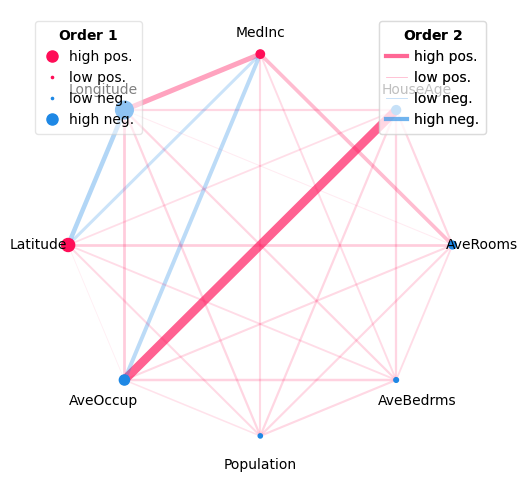

In [10]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

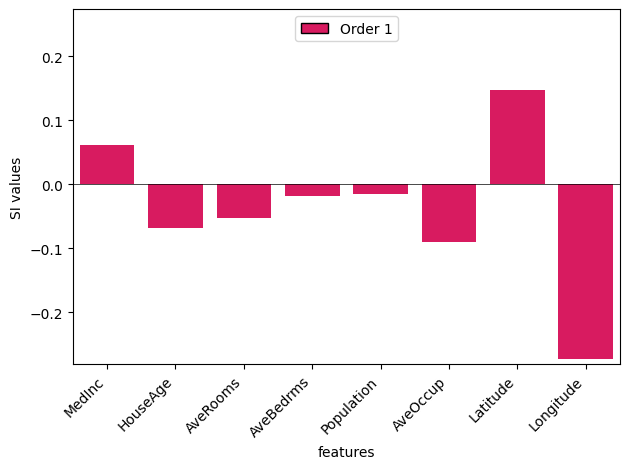

In [11]:
_ = shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=X.columns,
)

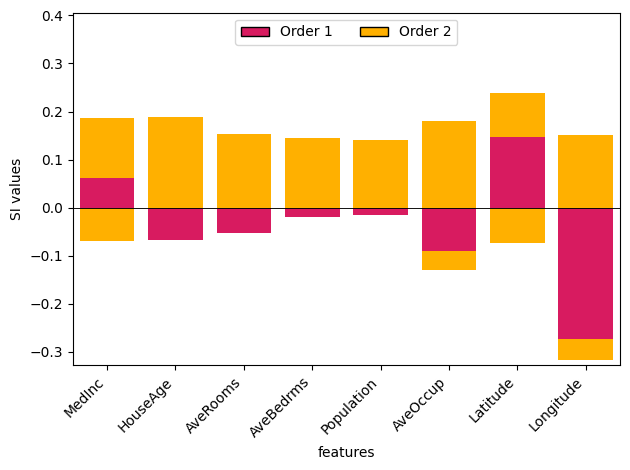

In [12]:
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

After installing the `shap` Python package.

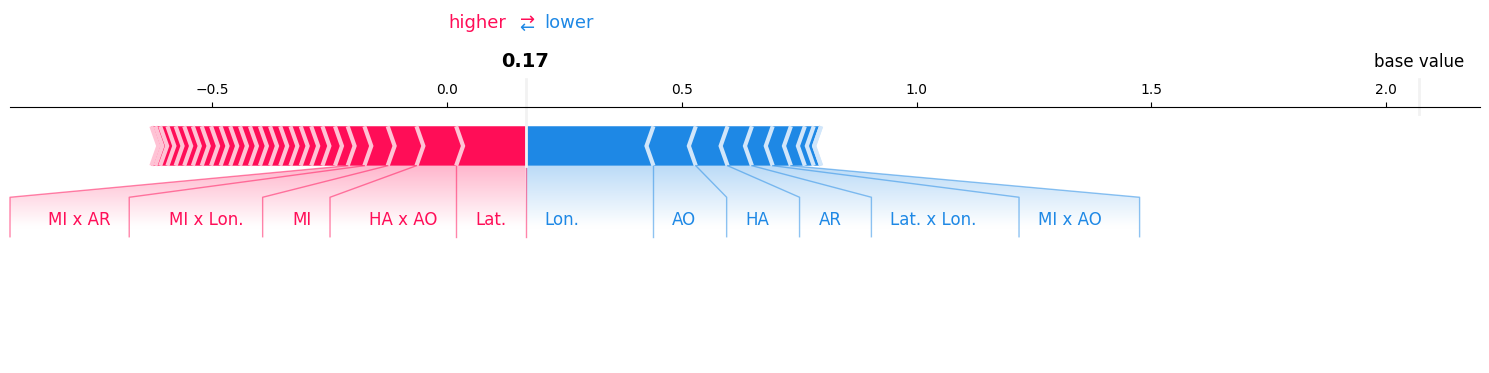

In [13]:
interaction_values.plot_force(feature_names=X.columns)